In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [2]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [3]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__() #этот модуль наследует модуль Module
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = modules[0].forward(input) #ошибка:)
            y_1    = modules[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        self.saved_inputs = {}  
        
        for i, module in enumerate(self.modules):
            self.saved_inputs[i] = input
            input = module.updateOutput(input)
        self.output = input

        
        return self.output
        

    def backward(self, input, gradOutput):
        grad = gradOutput
    
        for i in reversed(range(len(self.modules))):
            layer_input = self.saved_inputs[i]
            self.modules[i].accGradParameters(layer_input, grad)  # сначала накопим градиенты
            grad = self.modules[i].updateGradInput(layer_input, grad)
    
        self.gradInput = grad
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [4]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1.0 / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
      
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        
        self.gradW += gradOutput.T @ input;
        self.gradb += np.sum(gradOutput, axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    
    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [5]:
class SoftMax(Module):
    def __init__(self):
        super(SoftMax, self).__init__()
        self.output = None
        self.gradInput = None

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        # Your code goes here. ################################################

        exp_x = np.exp(self.output)

        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output


    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################

        self.gradInput = np.zeros_like(input)
        for i in range(input.shape[0]):

            self.gradInput[i] = self.output[i] * (gradOutput[i] - np.sum(self.output[i] * gradOutput[i]))

        return self.gradInput


        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [6]:
# class LogSoftMax:
#     def init(self):
#         pass

#     def updateOutput(self, input):
#         # Стабилизируем вход (вычтем максимум для численной устойчивости)
#         shifted_input = input - np.max(input, axis=1, keepdims=True)

#         # log(sum(exp(x))) — знаменатель
#         log_sum_exp = np.log(np.sum(np.exp(shifted_input), axis=1, keepdims=True))

#         # логарифм softmax
#         self.output = shifted_input - log_sum_exp

#         # сохраним softmax для backward
#         self.softmax = np.exp(self.output)

#         return self.output

#     def updateGradInput(self, input, gradOutput):
#         # Пусть: y = log_softmax(x), gradOutput = dL/dy
#         # Тогда: dL/dx = gradOutput - exp(y) * sum(gradOutput)

#         sum_grad = np.sum(gradOutput, axis=1, keepdims=True)  # (batch_size, 1)
#         self.gradInput = gradOutput - self.softmax * sum_grad

#         return self.gradInput

#     def repr(self):
#         return "LogSoftMax"

class LogSoftMax(Module):
    def init(self):
        pass

    def updateOutput(self, input):
        if input.ndim == 1:
            input = input.reshape(1, -1)
    
        shifted_input = input - np.max(input, axis=1, keepdims=True)
        log_sum_exp = np.log(np.sum(np.exp(shifted_input), axis=1, keepdims=True))
        self.output = shifted_input - log_sum_exp
        self.softmax = np.exp(self.output)
        return self.output
    

    def updateGradInput(self, input, gradOutput):
        if gradOutput.ndim == 1:
            gradOutput = gradOutput.reshape(1, -1)
    
        sum_grad = np.sum(gradOutput, axis=1, keepdims=True)
        self.gradInput = gradOutput - self.softmax * sum_grad
        return self.gradInput
        

    def getParameters(self):
        return []

    def getGradParameters(self):
        return []

    def zeroGradParameters(self):
        pass
    def evaluate(self):
        self.training = False

    def train(self):
        self.training = True


    def repr(self):
        return "LogSoftMax"


## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [7]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None
        self.training = True
        self.normalized_input = None

    def train(self, flag = True):
        self.training = flag
    def eval(self,):
        self.training = False
    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please

        if self.training:
            self.batch_mean = np.mean(input, axis=0)
            self.batch_var = np.var(input, axis=0)


            if self.moving_mean is None:
                self.moving_mean = self.batch_mean.copy()
                self.moving_variance = self.batch_var.copy()

            else:

                self.moving_mean = self.alpha * self.moving_mean + (1 - self.alpha) * self.batch_mean
                self.moving_variance = self.alpha * self.moving_variance + (1 - self.alpha) * self.batch_var


            self.normalized_input = (input - self.batch_mean) / np.sqrt(self.batch_var + self.EPS)
        else:
            self.normalized_input = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)


        return self.normalized_input


    def updateGradInput(self, input, gradOutput):

        if not self.training:
            self.gradInput = gradOutput / np.sqrt(self.moving_variance + self.EPS)
            return self.gradInput

        sigma = np.sqrt(self.batch_var + self.EPS)


        d_normalized = gradOutput
        d_var = np.sum(d_normalized * (input - self.batch_mean) * -0.5 * (self.batch_var + self.EPS)**(-1.5), axis=0)
        d_mean = np.sum(d_normalized * -1 / sigma, axis=0) + d_var * np.mean(-2 * (input - self.batch_mean), axis=0)
        self.gradInput = (d_normalized / sigma) + (d_var * 2 * (input - self.batch_mean) / input.shape[0]) + (d_mean / input.shape[0])

        return self.gradInput


    def getParameters(self):
        return []
    def getGradParameters(self):
        return []


    def __repr__(self):
        return "BatchNormalization"

In [8]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradGamma += np.sum(gradOutput * input, axis=0)
        self.gradBeta  += np.sum(gradOutput, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [9]:
class Dropout(Module):
    def __init__(self, p=0.5):
      super(Dropout, self).__init__()
      self.p = p
      self.training = True
      self.mask = None

    def updateOutput(self, input):
      # Your code goes here. ################################################
      if self.training:

        self.mask = (np.random.rand(*input.shape) > self.p) / (1 - self.p) # булевая маска
        self.output = input * self.mask
        return self.output
      else:
          return input


    def updateGradInput(self, input, gradOutput):
      # Your code goes here. ################################################
        if self.training:
            self.gradInput = gradOutput * self.mask
            return self.gradInput
        else:
            return gradOutput


    def __repr__(self):
        return "Dropout"

# 6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [11]:
# class Conv2d:
#     def __init__(self, in_channels, out_channels, kernel_size,
#                  stride=1, padding=0, bias=True, padding_mode='zeros'):
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
#         self.stride = stride if isinstance(stride, tuple) else (stride, stride)
#         self.padding = padding
#         self.use_bias = bias
#         self.padding_mode = padding_mode
#         self.training = True

#         self.weight = np.random.randn(out_channels, in_channels, *self.kernel_size).astype(np.float32)
#         self.bias = np.random.randn(out_channels).astype(np.float32) if bias else None

#     def train(self):
#         self.training = True

#     def evaluate(self):
#         self.training = False

#     def _get_padding(self, input_shape):
#         if isinstance(self.padding, str) and self.padding == 'same':
#             in_height, in_width = input_shape[2], input_shape[3]
#             kH, kW = self.kernel_size
#             sH, sW = self.stride

#             out_height = int(np.ceil(in_height / sH))
#             out_width = int(np.ceil(in_width / sW))

#             pad_h = max((out_height - 1) * sH + kH - in_height, 0)
#             pad_w = max((out_width - 1) * sW + kW - in_width, 0)

#             pad_top = pad_h // 2
#             pad_bottom = pad_h - pad_top
#             pad_left = pad_w // 2
#             pad_right = pad_w - pad_left

#             return (pad_top, pad_bottom, pad_left, pad_right)
#         elif isinstance(self.padding, int):
#             return (self.padding, self.padding, self.padding, self.padding)
#         elif isinstance(self.padding, tuple):
#             if len(self.padding) == 2:
#                 return (self.padding[0], self.padding[0], self.padding[1], self.padding[1])
#             elif len(self.padding) == 4:
#                 return self.padding
#         raise ValueError("Invalid padding format")

#     def pad_input(self, input, padding):
#         pad_top, pad_bottom, pad_left, pad_right = padding

#         if self.padding_mode == 'zeros':
#             mode = 'constant'
#             kwargs = {'constant_values': 0}
#         elif self.padding_mode == 'replicate':
#             mode = 'edge'
#             kwargs = {}
#         elif self.padding_mode == 'reflect':
#             mode = 'reflect'
#             kwargs = {}
#         else:
#             raise ValueError(f"Unsupported padding_mode: {self.padding_mode}")

#         pad_width = [
#             (0, 0),  # batch
#             (0, 0),  # channels
#             (pad_top, pad_bottom),
#             (pad_left, pad_right)
#         ]
#         return np.pad(input, pad_width=pad_width, mode=mode, **kwargs)

#     def updateOutput(self, input):
#         self.input = input
#         self.padding_vals = self._get_padding(input.shape)
#         input_padded = self.pad_input(input, self.padding_vals)
#         self.input_padded = input_padded

#         B, _, H_p, W_p = input_padded.shape
#         kH, kW = self.kernel_size
#         sH, sW = self.stride

#         out_H = (H_p - kH) // sH + 1
#         out_W = (W_p - kW) // sW + 1

#         output = np.zeros((B, self.out_channels, out_H, out_W), dtype=np.float32)

#         for b in range(B):
#             for oc in range(self.out_channels):
#                 for i in range(out_H):
#                     for j in range(out_W):
#                         h_start = i * sH
#                         w_start = j * sW
#                         region = input_padded[b, :, h_start:h_start+kH, w_start:w_start+kW]
#                         output[b, oc, i, j] = np.sum(region * self.weight[oc])
#                         if self.use_bias:
#                             output[b, oc, i, j] += self.bias[oc]

#         self.output = output
#         return output

#     def updateGradInput(self, input, gradOutput):
#         pad_top, pad_bottom, pad_left, pad_right = self.padding_vals
#         B, _, H_in, W_in = input.shape
#         _, _, H_out, W_out = gradOutput.shape
#         kH, kW = self.kernel_size
#         sH, sW = self.stride

#         grad_input_padded = np.zeros_like(self.input_padded, dtype=np.float32)

#         for b in range(B):
#             for oc in range(self.out_channels):
#                 for i in range(H_out):
#                     for j in range(W_out):
#                         h_start = i * sH
#                         w_start = j * sW
#                         grad = gradOutput[b, oc, i, j]
#                         grad_input_padded[b, :, h_start:h_start+kH, w_start:w_start+kW] += self.weight[oc] * grad

#         if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
#             self.gradInput = grad_input_padded[:, :, pad_top:grad_input_padded.shape[2]-pad_bottom,
#                                                pad_left:grad_input_padded.shape[3]-pad_right]
#         else:
#             self.gradInput = grad_input_padded

#         return self.gradInput

#     def __repr__(self):
#         return "Conv2d"


class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding
        self.use_bias = bias
        self.padding_mode = padding_mode
        self.training = True

        self.weight = np.random.randn(out_channels, in_channels, *self.kernel_size).astype(np.float32)
        self.bias = np.random.randn(out_channels).astype(np.float32) if bias else None
        self.grad_weight = np.zeros_like(self.weight, dtype=np.float32)
        if self.use_bias:
            self.grad_bias = np.zeros_like(self.bias, dtype=np.float32)


    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False

    def _get_padding(self, input_shape):
        if isinstance(self.padding, str) and self.padding == 'same':
            in_height, in_width = input_shape[2], input_shape[3]
            kH, kW = self.kernel_size
            sH, sW = self.stride

            out_height = int(np.ceil(in_height / sH))
            out_width = int(np.ceil(in_width / sW))

            pad_h = max((out_height - 1) * sH + kH - in_height, 0)
            pad_w = max((out_width - 1) * sW + kW - in_width, 0)

            pad_top = pad_h // 2
            pad_bottom = pad_h - pad_top
            pad_left = pad_w // 2
            pad_right = pad_w - pad_left

            return (pad_top, pad_bottom, pad_left, pad_right)
        elif isinstance(self.padding, int):
            return (self.padding, self.padding, self.padding, self.padding)
        elif isinstance(self.padding, tuple):
            if len(self.padding) == 2:
                return (self.padding[0], self.padding[0], self.padding[1], self.padding[1])
            elif len(self.padding) == 4:
                return self.padding
        raise ValueError("Invalid padding format")

    def pad_input(self, input, padding):
        pad_top, pad_bottom, pad_left, pad_right = padding

        if self.padding_mode == 'zeros':
            mode = 'constant'
            kwargs = {'constant_values': 0}
        elif self.padding_mode == 'replicate':
            mode = 'edge'
            kwargs = {}
        elif self.padding_mode == 'reflect':
            mode = 'reflect'
            kwargs = {}
        else:
            raise ValueError(f"Unsupported padding_mode: {self.padding_mode}")

        pad_width = [
            (0, 0),  # batch
            (0, 0),  # channels
            (pad_top, pad_bottom),
            (pad_left, pad_right)
        ]
        return np.pad(input, pad_width=pad_width, mode=mode, **kwargs)

    def updateOutput(self, input):
        self.input = input
        self.padding_vals = self._get_padding(input.shape)
        input_padded = self.pad_input(input, self.padding_vals)
        self.input_padded = input_padded

        B, _, H_p, W_p = input_padded.shape
        kH, kW = self.kernel_size
        sH, sW = self.stride

        out_H = (H_p - kH) // sH + 1
        out_W = (W_p - kW) // sW + 1

        output = np.zeros((B, self.out_channels, out_H, out_W), dtype=np.float32)

        for b in range(B):
            for oc in range(self.out_channels):
                for i in range(out_H):
                    for j in range(out_W):
                        h_start = i * sH
                        w_start = j * sW
                        region = input_padded[b, :, h_start:h_start+kH, w_start:w_start+kW]
                        output[b, oc, i, j] = np.sum(region * self.weight[oc])
                        if self.use_bias:
                            output[b, oc, i, j] += self.bias[oc]

        self.output = output
        return output

    def updateGradInput(self, input, gradOutput):
        pad_top, pad_bottom, pad_left, pad_right = self.padding_vals
        B, _, H_in, W_in = input.shape
        _, _, H_out, W_out = gradOutput.shape
        kH, kW = self.kernel_size
        sH, sW = self.stride

        grad_input_padded = np.zeros_like(self.input_padded, dtype=np.float32)

        for b in range(B):
            for oc in range(self.out_channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * sH
                        w_start = j * sW
                        grad = gradOutput[b, oc, i, j]
                        grad_input_padded[b, :, h_start:h_start+kH, w_start:w_start+kW] += self.weight[oc] * grad

        if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
            self.gradInput = grad_input_padded[:, :, pad_top:grad_input_padded.shape[2]-pad_bottom,
                                               pad_left:grad_input_padded.shape[3]-pad_right]
        else:
            self.gradInput = grad_input_padded

        return self.gradInput
    def getParameters(self):
        if self.use_bias:
            return [self.weight, self.bias]
        else:
            return [self.weight]

    def getGradParameters(self):
        if self.use_bias:
            return [self.grad_weight, self.grad_bias]
        else:
            return [self.grad_weight]

    def zeroGradParameters(self):
        self.grad_weight.fill(0)
        if self.use_bias:
            self.grad_bias.fill(0)

    def accGradParameters(self, input, gradOutput):
        B, _, H_out, W_out = gradOutput.shape
        kH, kW = self.kernel_size
        sH, sW = self.stride

        self.grad_weight = np.zeros_like(self.weight, dtype=np.float32)
        if self.use_bias:
            self.grad_bias = np.zeros_like(self.bias, dtype=np.float32)

        for b in range(B):
            for oc in range(self.out_channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * sH
                        w_start = j * sW
                        region = self.input_padded[b, :, h_start:h_start+kH, w_start:w_start+kW]
                        self.grad_weight[oc] += region * gradOutput[b, oc, i, j]
                        if self.use_bias:
                            self.grad_bias[oc] += gradOutput[b, oc, i, j]


    def __repr__(self):
        return "Conv2d"



#7 (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [12]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.input = input
        B, C, H, W = input.shape
        k, s, p = self.kernel_size, self.stride, self.padding

        padded = np.pad(input, ((0,0), (0,0), (p,p), (p,p)), mode='constant', constant_values=-np.inf)
        H_out = (H + 2*p - k) // s + 1
        W_out = (W + 2*p - k) // s + 1

        self.output = np.zeros((B, C, H_out, W_out), dtype=input.dtype)
        self.max_indices = np.zeros((B, C, H_out, W_out, 2), dtype=int)

        for b in range(B):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * s
                        w_start = j * s
                        window = padded[b, c, h_start:h_start+k, w_start:w_start+k]
                        max_idx = np.unravel_index(np.argmax(window), window.shape)
                        self.output[b, c, i, j] = window[max_idx]
                        self.max_indices[b, c, i, j] = (h_start + max_idx[0], w_start + max_idx[1])

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        B, C, H, W = input.shape
        k, s, p = self.kernel_size, self.stride, self.padding
        H_out, W_out = gradOutput.shape[2:]

        grad_input_padded = np.zeros((B, C, H + 2*p, W + 2*p), dtype=input.dtype)

        for b in range(B):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        h_idx, w_idx = self.max_indices[b, c, i, j]
                        grad_input_padded[b, c, h_idx, w_idx] += gradOutput[b, c, i, j]

        self.gradInput = grad_input_padded[:, :, p:p+H, p:p+W] if p > 0 else grad_input_padded
        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"


class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.input = input
        B, C, H, W = input.shape
        k, s, p = self.kernel_size, self.stride, self.padding

        padded = np.pad(input, ((0,0), (0,0), (p,p), (p,p)), mode='constant', constant_values=0)
        H_out = (H + 2*p - k) // s + 1
        W_out = (W + 2*p - k) // s + 1

        self.output = np.zeros((B, C, H_out, W_out), dtype=input.dtype)

        for b in range(B):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * s
                        w_start = j * s
                        window = padded[b, c, h_start:h_start+k, w_start:w_start+k]
                        self.output[b, c, i, j] = np.mean(window)

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        B, C, H, W = input.shape
        k, s, p = self.kernel_size, self.stride, self.padding
        H_out, W_out = gradOutput.shape[2:]

        grad_input_padded = np.zeros((B, C, H + 2*p, W + 2*p), dtype=input.dtype)

        for b in range(B):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * s
                        w_start = j * s
                        grad = gradOutput[b, c, i, j] / (k * k)
                        grad_input_padded[b, c, h_start:h_start+k, w_start:w_start+k] += grad

        self.gradInput = grad_input_padded[:, :, p:p+H, p:p+W] if p > 0 else grad_input_padded
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"

#8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [13]:
class GlobalMaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(GlobalMaxPool2d, self).__init__()
    def updateOutput(self, input):
        self.input = input
        B, C, H, W = input.shape
        self.output = np.max(input, axis=(2, 3), keepdims=True)
        self.max_indices = np.argmax(input.reshape(B, C, -1), axis=2)
        return self.output

    def updateGradInput(self, input, gradOutput):
        B, C, H, W = input.shape
        self.gradInput = np.zeros_like(input)
        flat_grad = self.gradInput.reshape(B, C, -1)
        for b in range(B):
            for c in range(C):
                idx = self.max_indices[b, c]
                flat_grad[b, c, idx] = gradOutput[b, c, 0, 0]
        self.gradInput = flat_grad.reshape(B, C, H, W)
        return self.gradInput

    def __repr__(self):
        return "GlobalMaxPool2d"


class GlobalAvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(GlobalAvgPool2d, self).__init__()
    def updateOutput(self, input):
        self.input = input
        B, C, H, W = input.shape
        self.output = np.mean(input, axis=(2, 3), keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        B, C, H, W = input.shape
        grad = gradOutput / (H * W)
        self.gradInput = np.ones_like(input) * grad
        return self.gradInput

    def __repr__(self):
        return "GlobalAvgPool2d"


#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [14]:
# class Flatten(Module):
#     def __init__(self, start_dim=0, end_dim=-1):
#         self.start_dim = start_dim
#         self.end_dim = end_dim

#     def updateOutput(self, input):
        
#         if self.start_dim < 0:
#             elf.start_dim += input.ndim
#         if self.end_dim < 0:
#             self.end_dim += input.ndim

#         shape_before = input.shape[:self.start_dim]
#         flatten_dim = int(np.prod(input.shape[self.start_dim:self.end_dim + 1]))
#         shape_after = input.shape[self.end_dim + 1:]

#         self.output_shape = shape_before + (flatten_dim,) + shape_after
#         self.output = input.reshape(self.output_shape)
#         return self.output

#     def updateGradInput(self, input, gradOutput):
#         self.gradInput = gradOutput.reshape(input.shape)
#         return self.gradInput

#     def __repr__(self):
#         return "Flatten"

class Flatten(Module):
    def __init__(self, start_dim=1, end_dim=-1):
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        # Защита от отрицательных индексов
        start_dim = self.start_dim if self.start_dim >= 0 else input.ndim + self.start_dim
        end_dim = self.end_dim if self.end_dim >= 0 else input.ndim + self.end_dim

        shape_before = input.shape[:start_dim]
        flatten_dim = int(np.prod(input.shape[start_dim:end_dim + 1]))
        shape_after = input.shape[end_dim + 1:]

        self.input_shape = input.shape
        self.output = input.reshape(shape_before + (flatten_dim,) + shape_after)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(self.input_shape)
        return self.gradInput

    def getParameters(self):
        return []

    def getGradParameters(self):
        return []

    def zeroGradParameters(self):
        pass

    def train(self): pass
    def evaluate(self): pass

    def __repr__(self):
        return f"Flatten"


# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [15]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [16]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.where(input > 0, input, self.slope * input)
        return self.output


    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        grad = np.where(input > 0, 1.0, self.slope)
        self.gradInput = grad * gradOutput
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [17]:
class ELU(Module):
    def __init__(self, alpha=1.0):
      super(ELU, self).__init__()
      self.alpha = alpha

    def updateOutput(self, input):
        self.output = np.where(input > 0, input, self.alpha * (np.exp(input) - 1))
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * np.where(input > 0, 1, self.output + self.alpha)
        return self.gradInput

    def __repr__(self):
        return f"ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [18]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):

        self.output = np.log(1 + np.exp(input))
        return self.output

    def updateGradInput(self, input, gradOutput):

        sigmoid = 1 / (1 + np.exp(-input))
        self.gradInput = gradOutput * sigmoid
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

# 13  (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [19]:
class Gelu(Module):  
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = (input * norm.cdf(input)).astype(np.float32)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = (gradOutput * (norm.cdf(input) + input * norm.pdf(input))).astype(np.float32)
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [20]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [21]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [22]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15

    def __init__(self):
        super(ClassNLLCriterionUnstable, self).__init__()
    def updateOutput(self, input, target):

        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        # Your code goes here. ################################################
        log_probs = np.log(input_clamp)
        self.output = -np.sum(target * log_probs) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        # Avoid numerical errors by clamping input to a small value epsilon
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        # Your code goes here. ################################################
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        self.gradInput = -target / input_clamp / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"


## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [23]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = -np.sum(target * input) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = -target / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

## Optimizer

In [24]:
class Adam:
    def __init__(self,parameters, gradParameters, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.parameters = parameters
        self.gradParameters = gradParameters
        
        self.lr = lr
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.eps = eps
        self.t = 0  
        self.m = None
        self.v = None

    def step(self):
        if self.m is None:
            self.m = [
                [np.zeros_like(p) for p in group]
                for group in self.parameters
            ]
            self.v = [
                [np.zeros_like(p) for p in group]
                for group in self.parameters
            ]

        self.t += 1
        for param_group, grad_group, m_group, v_group in zip(
            self.parameters, self.gradParameters, self.m, self.v
        ):
            for p, g, m, v in zip(param_group, grad_group, m_group, v_group):
                m[...] = self.beta1 * m + (1 - self.beta1) * g
                v[...] = self.beta2 * v + (1 - self.beta2) * (g ** 2)

                m_hat = m / (1 - self.beta1 ** self.t)
                v_hat = v / (1 - self.beta2 ** self.t)

                p[...] -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)


## Data

In [25]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(
    n_samples=5000,     
    n_features=30,       
    n_targets=3,        
    noise=0.4,          
)

print("X.shape:", X.shape)
print("y.shape:", y.shape)  

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X.shape: (5000, 30)
y.shape: (5000, 3)


In [26]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()
x_train = normalizer.fit_transform(x_train)
x_test = normalizer.transform(x_test)

## Training & Test loop + scheduler

In [74]:
def train_loop(model, crit, optimizer, X, y, batch_size=100):
    model.train()
    perm = np.random.permutation(len(X))
    X_shuffled = X[perm]
    y_shuffled = y[perm]
    batch_loss = []

    for i in range(0, len(X), batch_size):
        x_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        
        yp = model.forward(x_batch)
    
        loss = crit.forward(yp, y_batch)
        grad = crit.backward(yp, y_batch)
        model.backward(x_batch, grad)
        
        optimizer.step()
        
        
        model.zeroGradParameters()

        batch_loss.append(loss)

    return np.mean(batch_loss)

In [75]:
def test_loop(model, crit, X, y, batch_size=100):
    model.eval()
    perm = np.random.permutation(len(X))
    X_shuffled = X[perm]
    y_shuffled = y[perm]
    batch_loss = []
    
    for i in range(0, len(X), batch_size):
        x_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]
        

        
        yp = model.forward(x_batch)
        
        loss = crit.forward(yp, y_batch)
        batch_loss.append(loss)
        
        
    return np.array(batch_loss).mean()

In [76]:
class LRScheduler:
    def __init__(self, optimizer, initial_lr, gamma=0.2, step_size=50):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.gamma = gamma
        self.step_size = step_size

    def step(self, epoch):
        factor = self.gamma ** (epoch // self.step_size)
        self.optimizer.lr = self.initial_lr * factor

## MODELS

### SmallModel

In [77]:
class SmallModel(Module):
    def __init__(self):
        super(SmallModel, self).__init__()
        self.model = Sequential()
        self.model.add(Linear(30, 120))
        self.model.add(Dropout(0.5))
        self.model.add(LeakyReLU())
        self.model.add(Linear(120, 3))
        
    def forward(self, input):
        return self.model.forward(input)
        
    def backward(self, input, grad):
        return self.model.backward(input, grad)
        
    def zeroGradParameters(self):
        self.model.zeroGradParameters()

    def getParameters(self):
        return self.model.getParameters()

    def getGradParameters(self):
        return self.model.getGradParameters()

    def train(self):
        self.model.train()

    def eval(self):
        self.model.evaluate()

In [83]:
model = SmallModel()
crit = MSECriterion()
optimizer = Adam(model.getParameters(), model.getGradParameters(), lr=0.001)
scheduler = LRScheduler(optimizer, initial_lr=0.001, gamma=0.2, step_size=50)

num_epochs = 200
batch_size = 64
train_loss_list_small = []
test_loss_list_small = []

for epoch in range(num_epochs+1):
    scheduler.step(epoch)
    train_loss = train_loop(model, crit, optimizer, x_train, y_train, batch_size)
    test_loss = test_loop(model, crit, x_test, y_test, batch_size)
    train_loss_list_small.append(train_loss)
    test_loss_list_small.append(test_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, LR: {optimizer.lr:.6f}")
        print(f"TRAIN Loss: {train_loss:.4f}")
        print(f"TEST  Loss: {test_loss:.4f}")
        print('$' * 40)

Epoch 0, LR: 0.001000
TRAIN Loss: 109384.8848
TEST  Loss: 110231.7189
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 20, LR: 0.001000
TRAIN Loss: 78345.6748
TEST  Loss: 76245.3187
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 40, LR: 0.001000
TRAIN Loss: 44601.7517
TEST  Loss: 40816.2227
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 60, LR: 0.000200
TRAIN Loss: 38771.7611
TEST  Loss: 35330.9691
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 80, LR: 0.000200
TRAIN Loss: 37480.7331
TEST  Loss: 34039.3921
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 100, LR: 0.000040
TRAIN Loss: 36368.7300
TEST  Loss: 33128.4968
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 120, LR: 0.000040
TRAIN Loss: 36225.5725
TEST  Loss: 32974.2764
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 140, LR: 0.000040
TRAIN Loss: 36019.1126
TEST  Loss: 32937.6778
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 160, LR: 0.000008
TRAIN Loss: 36385.7768
TEST  Loss: 32893.7807
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch

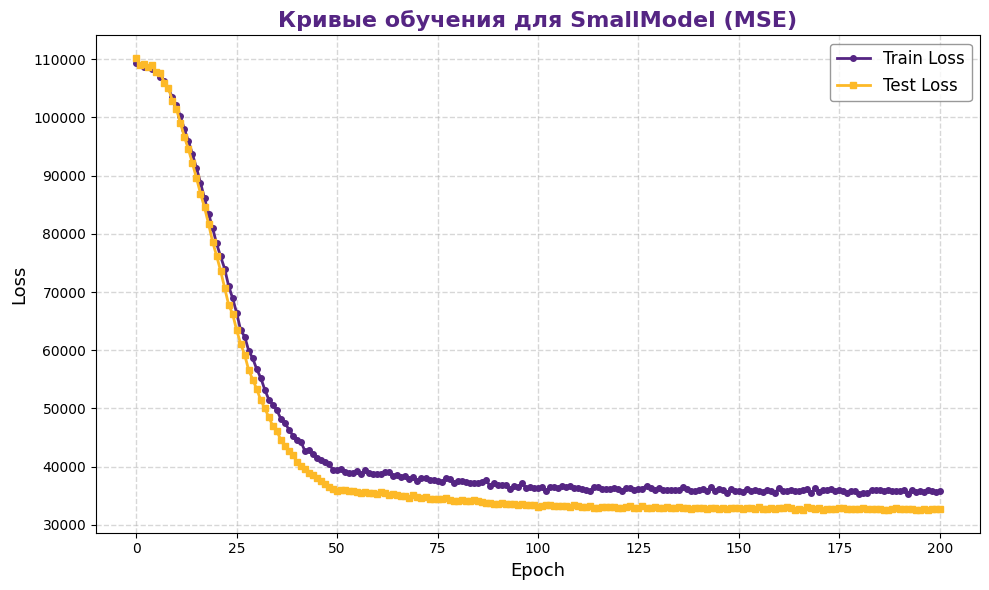

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list_small, label='Train Loss', linewidth=2, color='#552583', marker='o', markersize=4)  # фиолетовый
plt.plot(test_loss_list_small, label='Test Loss', linewidth=2, color='#FDB927', marker='s', markersize=4)   # жёлтый

plt.title('Кривые обучения для SmallModel (MSE)', fontsize=16, fontweight='bold', color='#552583')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)

plt.legend(fontsize=12, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

### MediumModel

In [32]:
class MediumModel(Module):
    def __init__(self):
        super(MediumModel, self).__init__()
        self.model = Sequential()
    
        self.model.add(Linear(30, 36))
        self.model.add(BatchNormalization(0.1))
        self.model.add(ChannelwiseScaling(36))
        self.model.add(Dropout(0.3))
        self.model.add(LeakyReLU())
        
        self.model.add(Linear(36, 100))
        self.model.add(Dropout(0.5))
        self.model.add(Gelu())
        
        self.model.add(Linear(100, 36))
        self.model.add(BatchNormalization(0.1))
        self.model.add(ReLU())
        
        self.model.add(Linear(36, 3))
        
        
    def forward(self, input):
        return self.model.forward(input)
        
    def backward(self, input, grad):
        return self.model.backward(input, grad)
        
    def zeroGradParameters(self):
        self.model.zeroGradParameters()

    def getParameters(self):
        return self.model.getParameters()

    def getGradParameters(self):
        return self.model.getGradParameters()

    def train(self):
        self.model.train()

    def eval(self):
        self.model.evaluate()


In [82]:
model = MediumModel()
crit = MSECriterion()
optimizer = Adam(model.getParameters(), model.getGradParameters(), lr=0.001)

scheduler = LRScheduler(optimizer, initial_lr=0.001, gamma=0.2, step_size=50)

num_epochs = 200
batch_size = 64
train_loss_list_medium = []
test_loss_list_medium = []

for epoch in range(num_epochs + 1):
    scheduler.step(epoch)
    train_loss = train_loop(model, crit, optimizer, x_train, y_train, batch_size)
    test_loss = test_loop(model, crit, x_test, y_test, batch_size)
    train_loss_list_medium.append(train_loss)
    test_loss_list_medium.append(test_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, LR: {optimizer.lr:.6f}")
        print(f"TRAIN Loss: {train_loss:.4f}")
        print(f"TEST  Loss: {test_loss:.4f}")
        print('$' * 40)

Epoch 0, LR: 0.001000
TRAIN Loss: 108931.5754
TEST  Loss: 108813.1162
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 20, LR: 0.001000
TRAIN Loss: 81737.8540
TEST  Loss: 81844.7977
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 40, LR: 0.001000
TRAIN Loss: 63450.1589
TEST  Loss: 50783.7399
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 60, LR: 0.000200
TRAIN Loss: 55077.2600
TEST  Loss: 56667.4687
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 80, LR: 0.000200
TRAIN Loss: 52406.9490
TEST  Loss: 53754.3374
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 100, LR: 0.000040
TRAIN Loss: 49566.2643
TEST  Loss: 40467.1737
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 120, LR: 0.000040
TRAIN Loss: 49255.4101
TEST  Loss: 48794.2772
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 140, LR: 0.000040
TRAIN Loss: 48760.4473
TEST  Loss: 52570.4799
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 160, LR: 0.000008
TRAIN Loss: 48103.2366
TEST  Loss: 37821.8644
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch

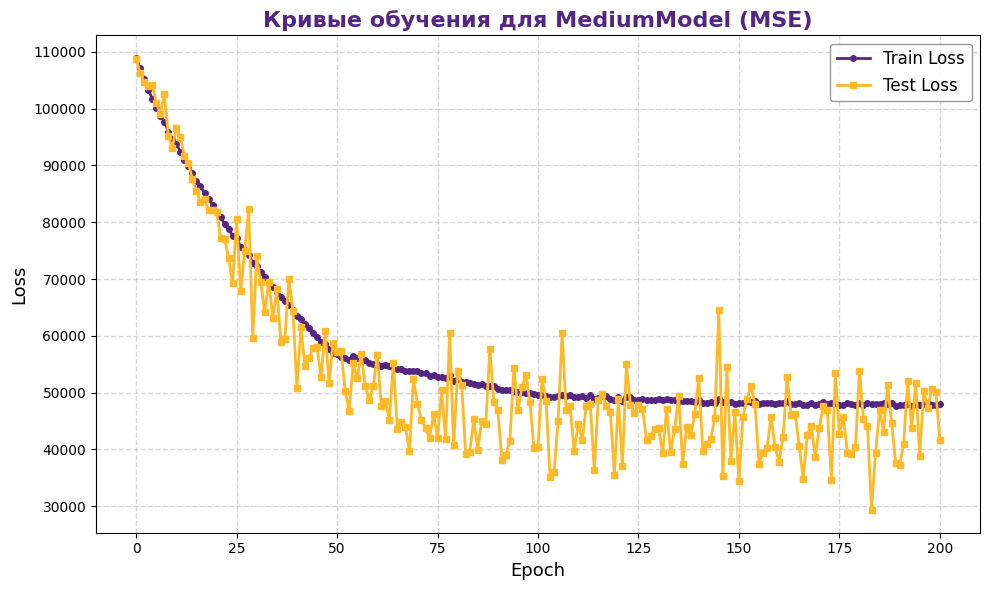

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list_medium, label='Train Loss', linewidth=2, color='#552583', marker='o', markersize=4)  # фиолетовый
plt.plot(test_loss_list_medium, label='Test Loss', linewidth=2, color='#FDB927', marker='s', markersize=4)   # жёлтый

plt.title('Кривые обучения для MediumModel (MSE)', fontsize=16, fontweight='bold', color='#552583')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)

plt.legend(fontsize=12, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

### LargeModel

In [35]:
class LargeModel(Module):
    def __init__(self):
        super(LargeModel, self).__init__()
        self.model = Sequential()
    
        self.model.add(Linear(30, 36))
        self.model.add(BatchNormalization(0.1))
        self.model.add(ChannelwiseScaling(36))
        self.model.add(LeakyReLU())
        
        self.model.add(Linear(36, 100))
        self.model.add(Gelu())

        self.model.add(Linear(100, 300))
        self.model.add(ELU())

        self.model.add(Linear(300, 100))
        self.model.add(Dropout(0.5))
        self.model.add(LeakyReLU())
        
        self.model.add(Linear(100, 36))
        self.model.add(Dropout(0.3))
        self.model.add(ReLU())
        
        self.model.add(Linear(36, 3))
        
        
    def forward(self, input):
        return self.model.forward(input)
        
    def backward(self, input, grad):
        return self.model.backward(input, grad)
        
    def zeroGradParameters(self):
        self.model.zeroGradParameters()

    def getParameters(self):
        return self.model.getParameters()

    def getGradParameters(self):
        return self.model.getGradParameters()

    def train(self):
        self.model.train()

    def eval(self):
        self.model.evaluate()


In [84]:
model = LargeModel()
crit = MSECriterion()
optimizer = Adam(model.getParameters(), model.getGradParameters(), lr=0.001)

scheduler = LRScheduler(optimizer, initial_lr=0.001, gamma=0.2, step_size=50)

num_epochs = 200
batch_size = 64
train_loss_list_large = []
test_loss_list_large = []

for epoch in range(num_epochs + 1):
    scheduler.step(epoch)  
    train_loss = train_loop(model, crit, optimizer, x_train, y_train, batch_size)
    test_loss = test_loop(model, crit, x_test, y_test, batch_size)
    train_loss_list_large.append(train_loss)
    test_loss_list_large.append(test_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, LR: {optimizer.lr:.6f}")
        print(f"TRAIN Loss: {train_loss:.4f}")
        print(f"TEST  Loss: {test_loss:.4f}")
        print('$' * 40)

Epoch 0, LR: 0.001000
TRAIN Loss: 108295.5807
TEST  Loss: 100995.2807
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 20, LR: 0.001000
TRAIN Loss: 21538.4046
TEST  Loss: 15251.1139
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 40, LR: 0.001000
TRAIN Loss: 20874.0116
TEST  Loss: 15561.8812
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 60, LR: 0.000200
TRAIN Loss: 20799.4747
TEST  Loss: 14946.6649
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 80, LR: 0.000200
TRAIN Loss: 21022.5557
TEST  Loss: 18197.7919
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 100, LR: 0.000040
TRAIN Loss: 20880.7897
TEST  Loss: 15386.0100
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 120, LR: 0.000040
TRAIN Loss: 20623.9584
TEST  Loss: 14887.2413
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 140, LR: 0.000040
TRAIN Loss: 20485.1300
TEST  Loss: 14765.4233
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 160, LR: 0.000008
TRAIN Loss: 20928.4822
TEST  Loss: 17231.5605
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch

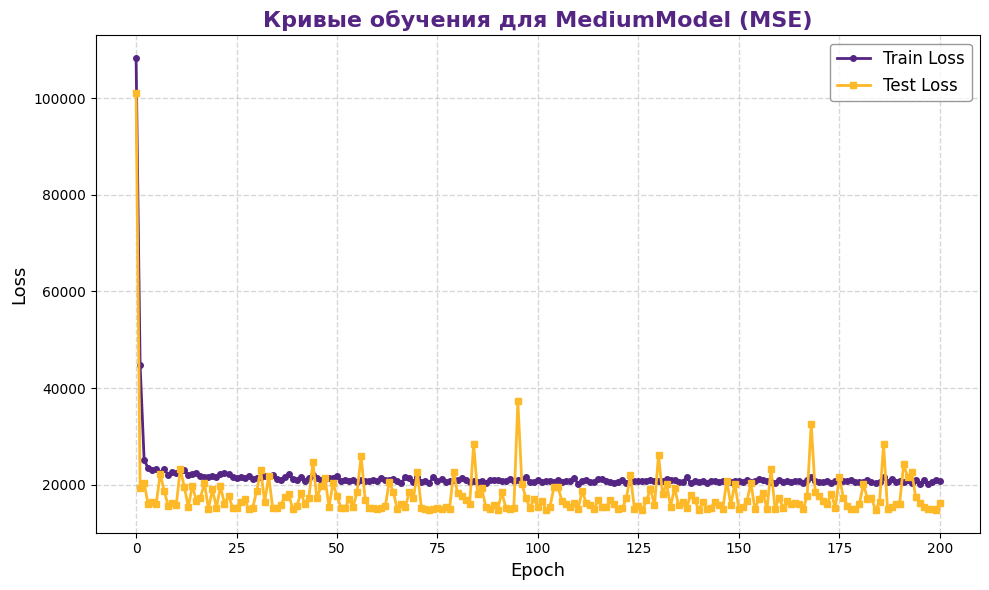

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list_large, label='Train Loss', linewidth=2, color='#552583', marker='o', markersize=4)  # фиолетовый
plt.plot(test_loss_list_large, label='Test Loss', linewidth=2, color='#FDB927', marker='s', markersize=4)   # жёлтый

plt.title('Кривые обучения для MediumModel (MSE)', fontsize=16, fontweight='bold', color='#552583')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)

plt.legend(fontsize=12, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

## MNIST

In [57]:
class NLLCriterion(Criterion):
    def __init__(self):
        super(NLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        input = np.array(input)
        target = np.array(target).astype(np.int64)  # важно!
        
        if target.ndim == 0:
            input = input.reshape(1, -1)
            target = target.reshape(1)
        
        self.output = -np.mean(input[np.arange(len(target)), target])
        return self.output

    def updateGradInput(self, input, target):
        input = np.array(input)
        target = np.array(target).astype(np.int64)

        if target.ndim == 0:
            input = input.reshape(1, -1)
            target = target.reshape(1)

        B, C = input.shape
        self.gradInput = np.zeros_like(input)
        self.gradInput[np.arange(B), target] = -1 / B
        return self.gradInput

    def __repr__(self):
        return "NLLCriterion"


In [58]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score


transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [59]:
from torch.utils.data import Subset

#запускаю 2% от датасета, а то комп собирается умирать
subset_size = int(len(train_dataset) * 0.02)

indices = torch.randperm(len(train_dataset))[:subset_size]

train_dataset = Subset(train_dataset, indices)

test_subset_size = 1000
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
test_dataset = Subset(test_dataset, test_indices)

In [60]:
class NumpyDataLoader:
    def __init__(self, dataset, batch_size=32, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(dataset)

    def __iter__(self):
        self.idx = 0
        if self.shuffle:
            self.permutation = np.random.permutation(self.num_samples)
        else:
            self.permutation = np.arange(self.num_samples)
        return self

    def __next__(self):
        if self.idx >= self.num_samples:
            raise StopIteration
        start = self.idx
        end = min(start + self.batch_size, self.num_samples)
        batch_idx = self.permutation[start:end]
        self.idx = end

        batch_x, batch_y = zip(*[self.dataset[i] for i in batch_idx])
        batch_x = torch.stack(batch_x).numpy()  
        batch_y = torch.tensor(batch_y).numpy() 

        return batch_x, batch_y

In [61]:
from tqdm import tqdm

In [62]:
def train_loop(model, crit, optimizer, dl):
    model.train()
    batch_loss = []
   
    for x_batch, y_batch in tqdm(dl):
        yp = model.forward(x_batch)

        loss = crit.forward(yp, y_batch)
        grad = crit.backward(yp, y_batch)
        model.backward(x_batch, grad)


        
        optimizer.step()
        model.zeroGradParameters()
        
        batch_loss.append(loss)

    return np.mean(batch_loss)


In [63]:
def test_loop(model, crit, dl):
    model.eval()
    batch_loss = []

    for x_batch, y_batch in dl:
        yp = model.forward(x_batch)

        loss = crit.forward(yp, y_batch)
    
        batch_loss.append(loss)
        
    return np.mean(batch_loss)

In [64]:
class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = Sequential()
        self.model.add(Conv2d(1, 8, 3))
        self.model.add(LeakyReLU())
        self.model.add(MaxPool2d(3,1, 1))
        self.model.add(Conv2d(8, 6, 3))
        self.model.add(AvgPool2d(2,2, 1))
        self.model.add(Flatten())
        self.model.add(Linear(1014, 128))
        self.model.add(Gelu())
        self.model.add(Linear(128, 10))
        self.model.add(LogSoftMax())

        
    def forward(self, input):
        return self.model.forward(input)
        
    def backward(self, input, grad):
        return self.model.backward(input, grad)
        
    def zeroGradParameters(self):
        self.model.zeroGradParameters()

    def getParameters(self):
        return self.model.getParameters()

    def getGradParameters(self):
        return self.model.getGradParameters()

    def train(self):
        self.model.train()

    def eval(self):
        self.model.evaluate()


In [66]:
model = CNN()
crit = NLLCriterion()
optimizer = Adam(model.getParameters(),model.getGradParameters(), lr=0.001)
traindl = NumpyDataLoader(train_dataset, batch_size=16, shuffle=True)
testdl = NumpyDataLoader(test_dataset, batch_size=16, shuffle=True)

num_epochs = 10
train_loss_list_mnist = []
test_loss_list_mnist = []


for epoch in range(num_epochs+1):
    train_loss =  train_loop(model, crit, optimizer, traindl)
    test_loss = test_loop(model, crit, testdl)
    
    train_loss_list_mnist.append(train_loss)
    test_loss_list_mnist.append(test_loss)
    
    if epoch%1==0:
        print('$'*40)
        print(f"Epoch {epoch}, TRAIN Loss: {train_loss:.4f}")
        print(f'Epoch {epoch}, TEST Loss: {test_loss:.4f}')

75it [03:41,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 0, TRAIN Loss: 0.8401
Epoch 0, TEST Loss: 0.3578


75it [03:41,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 1, TRAIN Loss: 0.2858
Epoch 1, TEST Loss: 0.2963


75it [03:41,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 2, TRAIN Loss: 0.2169
Epoch 2, TEST Loss: 0.2547


75it [03:41,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 3, TRAIN Loss: 0.1230
Epoch 3, TEST Loss: 0.2838


75it [03:41,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 4, TRAIN Loss: 0.1143
Epoch 4, TEST Loss: 0.2437


75it [03:41,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 5, TRAIN Loss: 0.0723
Epoch 5, TEST Loss: 0.1893


75it [03:41,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 6, TRAIN Loss: 0.0668
Epoch 6, TEST Loss: 0.2944


75it [03:40,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 7, TRAIN Loss: 0.0581
Epoch 7, TEST Loss: 0.1923


75it [03:41,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 8, TRAIN Loss: 0.0332
Epoch 8, TEST Loss: 0.2244


75it [03:41,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 9, TRAIN Loss: 0.0408
Epoch 9, TEST Loss: 0.3006


75it [03:40,  2.95s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 10, TRAIN Loss: 0.0308
Epoch 10, TEST Loss: 0.2249


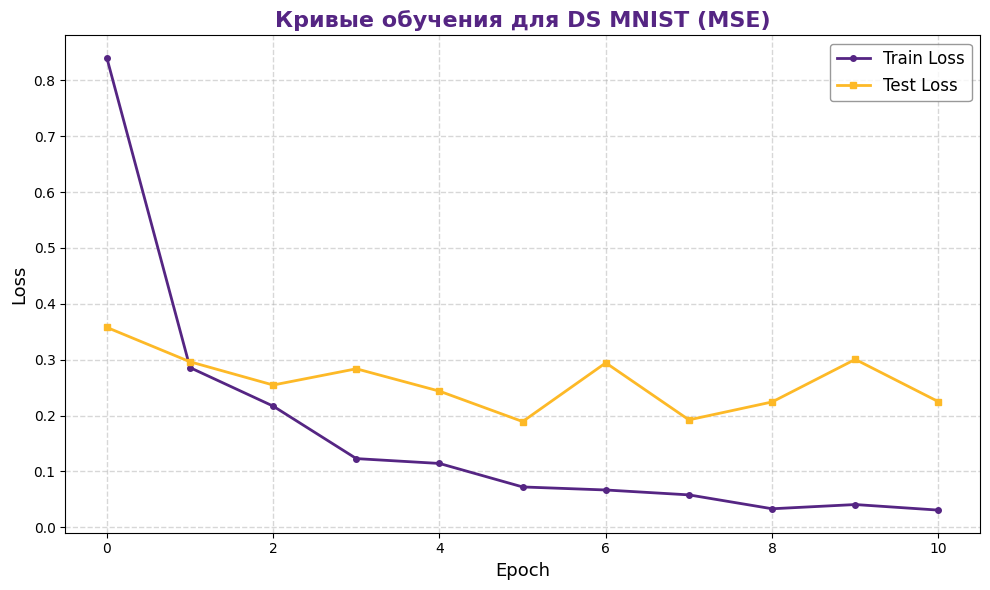

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list_mnist, label='Train Loss', linewidth=2, color='#552583', marker='o', markersize=4)  
plt.plot(test_loss_list_mnist, label='Test Loss', linewidth=2, color='#FDB927', marker='s', markersize=4)   

plt.title('Кривые обучения для DS MNIST (MSE)', fontsize=16, fontweight='bold', color='#552583')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)

plt.legend(fontsize=12, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

## Autoencoder

In [47]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score


transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


from torch.utils.data import Subset

subset_size = int(len(train_dataset) * 0.02)

indices = torch.randperm(len(train_dataset))[:subset_size]

train_dataset = Subset(train_dataset, indices)

test_subset_size = 220
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
test_dataset = Subset(test_dataset, test_indices)

In [48]:
class Upsample2d(Module):
    def __init__(self, scale=2):
        super(Upsample2d, self).__init__()
        self.scale = scale

    def updateOutput(self, input):
        self.input_shape = input.shape
        out = np.repeat(input, self.scale, axis=2)  
        out = np.repeat(out, self.scale, axis=3)    
        self.output = out
        return self.output

    def updateGradInput(self, input, gradOutput):
        B, C, H, W = self.input_shape
        scale = self.scale
        grad = gradOutput.reshape(B, C, H, scale, W, scale)
        self.gradInput = grad.mean(axis=(3, 5)) 
        return self.gradInput

    def getParameters(self):
        return []
    def getGradParameters(self):
        return []
    def zeroGradParameters(self):
        pass
    def train(self):
        pass
    def evaluate(self):
        pass

    def __repr__(self):
        return f"Upsample2d"

In [49]:
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def updateOutput(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def updateGradInput(self, input, gradOutput):
        sigmoid = self.output 
        self.gradInput = gradOutput * sigmoid * (1 - sigmoid)
        return self.gradInput

    def getParameters(self):
        return []
    def getGradParameters(self):
        return []
    def zeroGradParameters(self):
        pass
    def train(self):
        pass
    def evaluate(self):
        pass

    def __repr__(self):
        return "Sigmoid"

In [50]:
class Reshape(Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.target_shape = shape

    def updateOutput(self, input):
        self.input_shape = input.shape
        
        shape = tuple(self.target_shape)
        shape = (input.shape[0],) + shape[1:] if shape[0] == -1 else shape
        self.output = input.reshape(shape)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(self.input_shape)
        return self.gradInput

    def getParameters(self):
        return []
    def getGradParameters(self):
        return []
    def zeroGradParameters(self):
        pass
    def train(self):
        pass
    def evaluate(self):
        pass

    def __repr__(self):
        return f"Reshape"

In [51]:
class Autoencoder(Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.model = Sequential() 

        # --- ENCODER ---
        self.model.add(Conv2d(1, 16, 3, padding=1))         
        self.model.add(LeakyReLU())
        self.model.add(MaxPool2d(2, 2,  padding=0))                     
        self.model.add(Dropout(0.2))

        self.model.add(Conv2d(16, 32, 3, padding=1))      
        self.model.add(LeakyReLU())
        self.model.add(AvgPool2d(2, 2, padding=0))                    
        self.model.add(Dropout(0.2))

        # --- BOTTLENECK ---
        self.model.add(Flatten())                        
        self.model.add(Linear(1568, 128))
        self.model.add(BatchNormalization(0.1))
        self.model.add(ChannelwiseScaling(128))
        self.model.add(Gelu())
        self.model.add(Linear(128, 1568))
        self.model.add(Gelu())

        # --- DECODER ---
        self.model.add(Reshape((-1, 32, 7, 7)))            
        self.model.add(Upsample2d(scale=2))                
        self.model.add(Conv2d(32, 16, 3, padding=1))        
        self.model.add(LeakyReLU())
        self.model.add(Upsample2d(scale=2))                
        self.model.add(Conv2d(16, 1, 3, padding=1))

        
        self.model.add(Sigmoid())                          

    def forward(self, input):
        return self.model.forward(input)

    def backward(self, input, grad):
        return self.model.backward(input, grad)

    def zeroGradParameters(self):
        self.model.zeroGradParameters()

    def getParameters(self):
        return self.model.getParameters()

    def getGradParameters(self):
        return self.model.getGradParameters()

    def train(self):
        self.model.train()

    def eval(self):
        self.model.evaluate()

In [52]:
def train_loop(model, crit, optimizer, dl):
    model.train()
    batch_loss = []
   
    for x_batch, y_batch in tqdm(dl):
        yp = model.forward(x_batch)

        loss = crit.forward(yp, x_batch)
        grad = crit.backward(yp, x_batch)
        
        model.backward(x_batch, grad)


        
        optimizer.step()
        model.zeroGradParameters()
        
        batch_loss.append(loss)

    return np.mean(batch_loss)


In [53]:
def test_loop(model, crit, dl):
    model.eval()
    batch_loss = []

    for x_batch, y_batch in dl:
        yp = model.forward(x_batch)

        
        loss = crit.forward(yp, x_batch)
        
    
        batch_loss.append(loss)
        
    return np.mean(batch_loss)

In [54]:
model = Autoencoder()
crit = MSECriterion()

optimizer = Adam(model.getParameters(),model.getGradParameters(), lr=0.001)
traindl = NumpyDataLoader(train_dataset, batch_size=16, shuffle=True)
testdl = NumpyDataLoader(test_dataset, batch_size=16, shuffle=True)

num_epochs = 5
train_loss_list = []
test_loss_list = []


for epoch in range(num_epochs+1):
    train_loss =  train_loop(model, crit, optimizer, traindl)
    test_loss = test_loop(model, crit, testdl)
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    if epoch%1==0:
        print('$'*40)
        print(f"Epoch {epoch}, TRAIN Loss: {train_loss:.4f}")
        print(f'Epoch {epoch}, TEST Loss: {test_loss:.4f}')

75it [08:24,  6.73s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 0, TRAIN Loss: 334.5252
Epoch 0, TEST Loss: 79.7585


75it [08:21,  6.69s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 1, TRAIN Loss: 56.7780
Epoch 1, TEST Loss: 41.4166


75it [08:21,  6.69s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 2, TRAIN Loss: 39.0301
Epoch 2, TEST Loss: 30.4843


75it [08:21,  6.69s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 3, TRAIN Loss: 32.0454
Epoch 3, TEST Loss: 29.6045


75it [08:22,  6.69s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 4, TRAIN Loss: 28.7968
Epoch 4, TEST Loss: 22.9852


75it [08:22,  6.69s/it]


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Epoch 5, TRAIN Loss: 26.5953
Epoch 5, TEST Loss: 20.0492


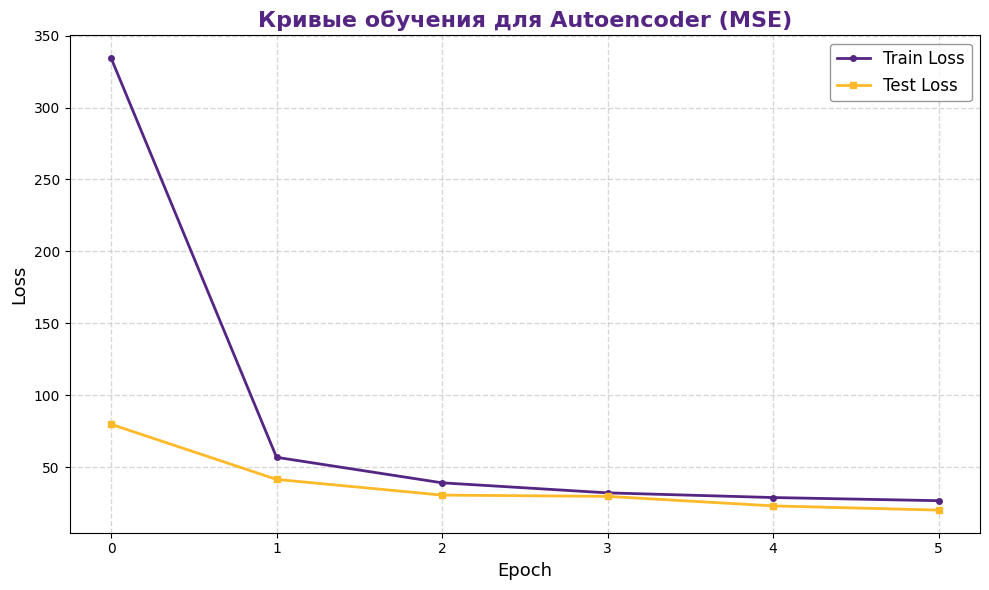

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Train Loss', linewidth=2, color='#552583', marker='o', markersize=4)  
plt.plot(test_loss_list, label='Test Loss', linewidth=2, color='#FDB927', marker='s', markersize=4)   

plt.title('Кривые обучения для Autoencoder (MSE)', fontsize=16, fontweight='bold', color='#552583')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)

plt.legend(fontsize=12, loc='upper right', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()